In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import os
from tqdm.auto import tqdm
from glob import glob
import cv2
import numpy as np
import pandas as pd
import PIL 
import urllib
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from random import uniform
from imgaug import augmenters as iaa

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [ ]:
import torch.utils.data as td
import torchvision as tv
from PIL import Image
import matplotlib.pyplot as plt
import time

In [ ]:
!pip install pydicom

     |████████████████████████████████| 1.9 MB 8.0 MB/s 


In [ ]:
import pydicom as dcm

In [ ]:
from google.colab import drive
drive.mount._DEBUG = True
drive.mount('/content/drive', force_remount=True)

unset HISTFILE; export PS1="root@6a76c0b05337-f280065fa00c46b5b4089f2c4d655d76: "
bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
/content# root@6a76c0b05337-f280065fa00c46b5b4089f2c4d655d76: umount -f /content/drive || umount /content/drive; pkill -9 -x drive
umount: /content/drive: no mount point specified.
umount: /content/drive: no mount point specified.
root@6a76c0b05337-f280065fa00c46b5b4089f2c4d655d76: pkill -9 -f /opt/google/drive/directoryprefetcher_binary
root@6a76c0b05337-f280065fa00c46b5b4089f2c4d655d76: ( while `sleep 0.5`; do if [[ -d "/content/drive" && "$(ls -A /content/drive)" != "" ]]; then echo "google.colab.drive MOUNTED"; break; fi; done ) &
[1] 158
root@6a76c0b05337-f280065fa00c46b5b4089f2c4d655d76: cat /tmp/tmpujk_g1_2/drive.fifo | head -1 | ( /opt/google/drive/drive --features=fuse_max_background:1000,max_read_qps:1000,max_write_qps:1000,max_operation_batch_size:15,max_parallel_push_task_instances:1

In [ ]:
os.chdir('./drive/MyDrive/body-morphometry-kidney-and-tumor/data/')

전처리


*   https://github.com/tuvovan/Unet-with-EfficientnetB7-Backbone/blob/master/Body%20Morphometry.ipynb


모델


*   https://github.com/IanTaehoonYoo/semantic-segmentation-pytorch




In [ ]:
from skimage.transform import resize
from skimage.io import imread
from tensorflow.keras.preprocessing.image import load_img
import numpy as np
import pydicom

def transform_to_hu(medical_image, image):
    hu_image = image * medical_image.RescaleSlope + medical_image.RescaleIntercept
    hu_image[hu_image < -1024] = -1024
    return hu_image

def window_image(image, window_center, window_width):
    window_image = image.copy()
    image_min = window_center - (window_width / 2)
    image_max = window_center + (window_width / 2)
    window_image[window_image < image_min] = image_min
    window_image[window_image > image_max] = image_max
    return window_image

def resize_normalize(image):
    image = np.array(image, dtype=np.float64)
    image -= np.min(image)
    image /= np.max(image)
    return image

def read_dicom(image_medical, window_widht, window_level):
    image_data = image_medical.pixel_array

    image_hu = transform_to_hu(image_medical, image_data)
    image_window = window_image(image_hu.copy(), window_level, window_widht)
    image_window_norm = resize_normalize(image_window)
#     image_window_norm = image_window

    image_window_norm = np.expand_dims(image_window_norm, axis=2)   # (512, 512, 1)
    image_ths = np.concatenate([image_window_norm, image_window_norm, image_window_norm], axis=2)   # (512, 512, 3)
    return image_ths

def to_binary(img, lower, upper):
    return (lower <= img) & (img <= upper)

In [ ]:
pip install albumentations==0.3.1

     |████████████████████████████████| 78 kB 4.9 MB/s 
     |████████████████████████████████| 37.1 MB 75 kB/s 
     |████████████████████████████████| 631 kB 70.2 MB/s 
  Created wheel for albumentations: filename=albumentations-0.3.1-py3-none-any.whl size=47861 sha256=6c916b29ceb6b33926b318c368dc3af5cbb1a2ee784bbb01f131cb07c121b026
  Stored in directory: /root/.cache/pip/wheels/db/51/fd/1d5d1bcf5bcecec185bfe177cf132fc87e29a0a9a8d782e0b7
  Created wheel for imgaug: filename=imgaug-0.2.6-py3-none-any.whl size=654020 sha256=d128a5b799f6200fb26e6ec25182f9af4bc7a6fbe812b7a2c0fa4d2b3544d500
  Stored in directory: /root/.cache/pip/wheels/89/72/98/3ebfdba1069a9a8eaaa7ae7265cfd67d63ef0197aaee2e5f9c
Successfully built albumentations imgaug
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninsta

In [ ]:
albumentations.__version__

'0.1.12'

In [ ]:
import albumentations as A
import albumentations.pytorch

aug = A.Compose([
                 A.augmentations.transforms.HorizontalFlip(p=0.5,always_apply=False),
                 A.OneOf([
                          A.RandomContrast(always_apply=False,p=0.2,limit=[-0.1,0.1]),
                          A.RandomGamma(always_apply=False,p=0.2,gamma_limit=[80,120]),
                          A.RandomBrightness(always_apply=False,p=0.2,limit=[-0.1,0.1])
                          ], p=0.5)
                #  A.OneOf([
                #           A.augmentations.transforms.ElasticTransform(always_apply=False,p=0.2,alpha=10,sigma=6.0,alpha_affine=1.5999999999999996,interpolation=1,border_mode=4,approximate=False),
                #           # albumentations.augmentations.transforms.GridDistortion(always_apply=False,p=0.2,num_steps=5,distort_limit=[-0.1,0.1],interpolation=1,border_mode=4),
                #           A.augmentations.transforms.OpticalDistortion(always_apply=False,p=0.4,distort_limit=[-2,2],shift_limit=[-0.5,0.5],interpolation=1,border_mode=4),                 
                #           ], p=0.3),
                          #  albumentations.augmentations.transforms.Cutout(always_apply=False,p=0.5,num_holes=8,max_h_size=50,max_w_size=50)
                          #  albumentations.augmentations.transforms.ShiftScaleRotate(always_apply=False,p=0.5,shift_limit=[-0.0625,0.0625],scale_limit=[-0.09999999999999998,0.12000000000000009],rotate_limit=[-25,25],interpolation=1,border_mode=4,value=null,mask_value=null),
                          # albumentations.augmentations.transforms.Resize(always_apply=True,p=1,height=512,width=512,interpolation=1)

                    ])

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, x_dir, y_dir, transform=None):
        super().__init__()

        self.transforms = transform
        self.x_img = x_dir
        self.y_img = y_dir   

    def __len__(self):
        return len(self.x_img)

    def __getitem__(self, idx):
        x_img = self.x_img[idx]
        y_img = self.y_img[idx]
        # Read an image with OpenCV
        x_img = dcm.read_file(x_img)
        y_img =  imread(y_img)

        x_img=read_dicom(x_img,500,0)
        x_img=np.transpose(x_img,(2,0,1))
        x_img=x_img.astype(np.float32)

        y_img = resize(y_img, (512, 512))*255

        
        color_im = np.zeros([512, 512, 2])
        for i in range(1,3):
            encode_ = to_binary(y_img, i*1.0, i*1.0) * 255
            color_im[:, :, i-1] = encode_
        color_im = np.transpose(color_im,(2,0,1))

        # Data Augmentation
        if self.transforms:
            augmented = self.transforms(image=x_img,mask=color_im)
            img = augmented['image']
            mask = augmented['mask']
            return img, mask,y_img

In [ ]:
import glob
data_path=sorted(glob.glob( "./train/DICOM/**/*.dcm",recursive=True ))
label_path=sorted(glob.glob("./train/Label/**/*.png",recursive = True))

In [ ]:
data_path = pd.array(data_path)
label_path = pd.array(label_path)

train_input_files = data_path[0:].to_numpy()
train_label_files = label_path[0:].to_numpy()

val_input_files = data_path[:12].to_numpy()
val_label_files = label_path[:12].to_numpy()

In [ ]:
train_dataset = MyDataset(train_input_files,train_label_files,aug)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=8,shuffle=True)
val_dataset = MyDataset(val_input_files,val_label_files,aug)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=8,shuffle=True)

torch.Size([8, 3, 512, 512])
torch.Size([8, 2, 512, 512])


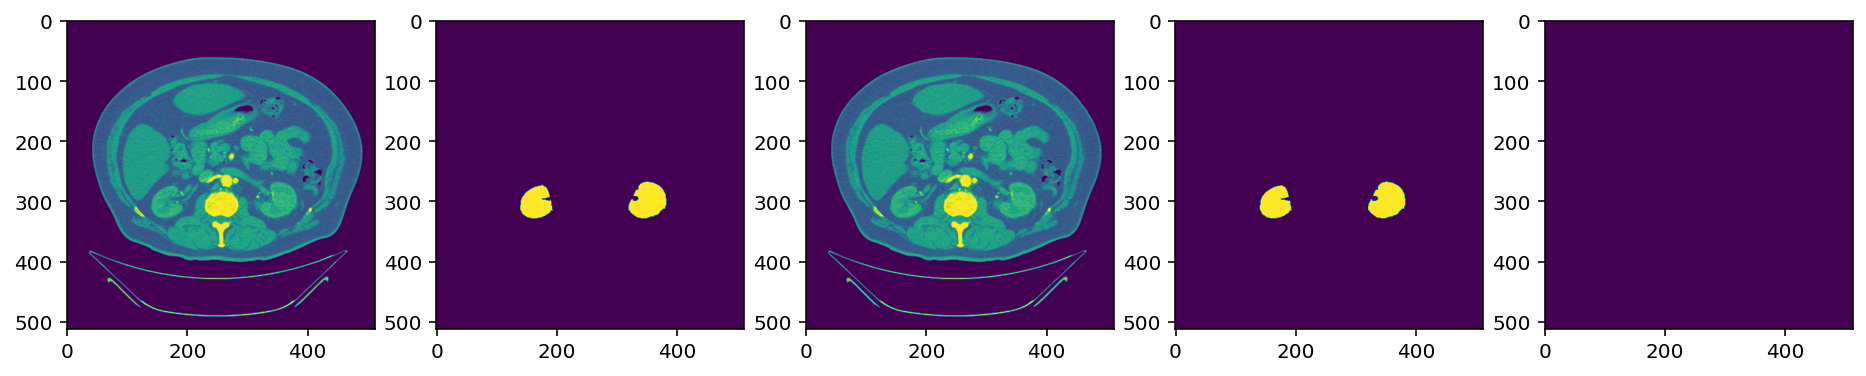

In [ ]:
##input과 label이 맞나 확인
origin_img,origin_mask,images,mask = next(iter(train_loader))
print(images.shape)
print(mask.shape)
plt.figure(figsize=(16,18))
plt.subplot(1,5,1)
plt.imshow(origin_img[0][0])
plt.subplot(1,5,2)
plt.imshow(origin_mask[0])
plt.subplot(1,5,3)
plt.imshow(images[0][0])
plt.subplot(1,5,4)
plt.imshow(mask[0][0])
plt.subplot(1,5,5)
plt.imshow(mask[0][1])

plt.show()

In [ ]:
def compute_per_channel_dice(input, target, epsilon=1e-5, ignore_index=None, weight=None):
    # assumes that input is a normalized probability
    # input and target shapes must match
    assert input.size() == target.size(), "'input' and 'target' must have the same shape"

    # mask ignore_index if present
    if ignore_index is not None:
        mask = target.clone().ne_(ignore_index)
        mask.requires_grad = False

        input = input * mask
        target = target * mask

    input = flatten(input)
    target = flatten(target)

    # Compute per channel Dice Coefficient
    intersect = (input * target).sum(-1)
    if weight is not None:
        intersect = weight * intersect

    denominator = (input + target).sum(-1)
    return 2. * intersect / denominator.clamp(min=epsilon)

def flatten(tensor):
    """Flattens a given tensor such that the channel axis is first.
    The shapes are transformed as follows:
       (N, C, D, H, W) -> (C, N * D * H * W)
    """
    C = tensor.size(1)
    # new axis order
    axis_order = (1, 0) + tuple(range(2, tensor.dim()))
    # Transpose: (N, C, D, H, W) -> (C, N, D, H, W)
    transposed = tensor.permute(axis_order).contiguous()
    # Flatten: (C, N, D, H, W) -> (C, N * D * H * W)
    return transposed.view(C, -1)

class DiceLoss(nn.Module):
    """Computes Dice Loss, which just 1 - DiceCoefficient described above.
    Additionally allows per-class weights to be provided.
    """

    def __init__(self, epsilon=1e-5, weight=None, ignore_index=None, sigmoid_normalization=True,
                 skip_last_target=False):
        super(DiceLoss, self).__init__()
        if isinstance(weight, list):
            weight = torch.Tensor(weight)
            
        self.epsilon = epsilon
        self.register_buffer('weight', weight)
        self.ignore_index = ignore_index

        if sigmoid_normalization:
            self.normalization = nn.Sigmoid()
        else:
            self.normalization = nn.Softmax(dim=1)
        # if True skip the last channel in the target
        self.skip_last_target = skip_last_target

    def forward(self, input, target):
        # get probabilities from logits

        input = self.normalization(input)
        if self.weight is not None:
            weight = Variable(self.weight, requires_grad=False).to(input.device)
        else:
            weight = None

        if self.skip_last_target:
            target = target[:, :-1, ...]

        per_channel_dice = compute_per_channel_dice(input, target, epsilon=self.epsilon, ignore_index=self.ignore_index, weight=weight)
        # Average the Dice score across all channels/classes
        return torch.mean(1. - per_channel_dice)

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-xxltftm6
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-xxltftm6
     |████████████████████████████████| 58 kB 4.5 MB/s 
     |████████████████████████████████| 376 kB 15.6 MB/s 
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.2.0-py3-none-any.whl size=88675 sha256=e685e86b66570111f979367e75d2ba75ae7cec14f4334aae158d21551954cd58
  Stored in directory: /tmp/pip-ephem-wheel-cache-hf9wspkh/wheels/fa/c5/a8/1e8af6cb04a0974db8a4a156ebd2fdd1d99ad2558d3fce49d4
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=f5a95ffbb32c495f4b564c626fb64c16b0c9c643327a84873b6356c94c485e78
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-n

In [ ]:
import segmentation_models_pytorch as smp
model = smp.FPN(
    encoder_name="resnext101_32x8d",# choose encoder, e.g. mobilenet_v2 or efficientnet-b7 resnext101_32x8d,timm-res2net101_26w_4s     # use `imagenet` pre-trained weights for encoder initialization 
    encoder_weights="imagenet",
    in_channels=3,
    # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=2,                      # model output channels (number of classes in your dataset)
)

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth


  0%|          | 0.00/340M [00:00<?, ?B/s]

In [ ]:
import torch.optim as optim
criterion =  DiceLoss(sigmoid_normalization=True)
optimizer = optim.Adam(model.parameters(),lr=0.00001)

In [ ]:
sum([param.nelement() for param in model.parameters()])

89350466

In [ ]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
    
device

'cuda'

In [ ]:
n_epochs = 50
cnt =0
valid_loss_min = np.inf # track change in validation loss

# keep track of training and validation loss
train_loss = torch.zeros(n_epochs)
valid_loss = torch.zeros(n_epochs)

model.to(device)
for e in range(0, n_epochs):

   
    ###################
    # train the model #
    ###################
    model.train()
    for data, labels,a in tqdm(train_loader):
        # move tensors to GPU if CUDA is available
        data, labels = data.to(device), labels.to(device) #cpu에 있는 데이터를 gpu에 보냄
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        logits = model(data)
        # calculate the batch loss
        loss = criterion(logits, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss[e] += loss.item()

        logits = logits.sigmoid()
        logits = logits.detach().cpu()

        cnt = cnt+1
        
        if cnt %100==0:
            
            y=logits[0].detach().cpu().numpy()
            x=labels[0].detach().cpu().numpy()
            plt.figure(figsize=(16,18))
            plt.subplot(1,5,1)
            plt.imshow(x[0])
            plt.subplot(1,5,2)
            plt.imshow(x[1])
            plt.subplot(1,5,3)
            plt.imshow(y[0])
            plt.subplot(1,5,4)
            plt.imshow(y[1])
            plt.subplot(1,5,5)
            plt.imshow(a[0])
            plt.show()
        
        
        
    
    train_loss[e] /= len(train_loader)
        
        
    ######################    
    # validate the model #
    ######################
    with torch.no_grad(): 
        model.eval()
        for data, labels,a in tqdm(val_loader):
            # move tensors to GPU if CUDA is available
            data, labels = data.to(device), labels.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            logits = model(data)
            # calculate the batch loss
            loss = criterion(logits, labels)
            # update average validation loss 
            valid_loss[e] += loss.item()

    
    # calculate average losses
    valid_loss[e] /= len(val_loader)
    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e, train_loss[e], valid_loss[e]))
    
    # save model if validation loss has decreased
    if valid_loss[e] <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss[e]))
        torch.save(model.state_dict(), 'model_simpleAlbu.pt')
        valid_loss_min = valid_loss[e]

In [ ]:
model.load_state_dict(torch.load('model_simpleAlbu.pt'))

In [ ]:
class TestMyDataset(torch.utils.data.Dataset):
    def __init__(self, x_dir,transform=None):
        super().__init__()
        self.transform = transform
        self.x_img = x_dir
     

    def __len__(self):
        return len(self.x_img)

    def __getitem__(self, idx):
        x_img = self.x_img[idx]
        # Read an image with OpenCV
        x_img = dcm.dcmread(x_img)
        x_img=read_dicom(x_img,400,50)
        x_img=np.transpose(x_img,(2,0,1))
        x_img=x_img.astype(np.float32)
        
       
        return x_img

In [ ]:
test_path=sorted(glob.glob( "./test/DICOM/**/*.dcm",recursive=True ))

In [ ]:
test_dataset = TestMyDataset(test_path)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1,shuffle=False)

In [ ]:
def mask_binarization(mask, threshold=None):
    if threshold is None:
        threshold = 0.5

    if isinstance(mask, np.ndarray):
        mask_binarized = (mask > threshold).astype(np.uint8)
    
    elif isinstance(mask, torch.Tensor):
        zeros = torch.zeros_like(mask)
        ones = torch.ones_like(mask)
        
        mask_binarized = torch.where(mask > threshold, ones, zeros)
    
    return mask_binarized

In [ ]:
def rle_encode(mask_image):
    pixels = mask_image.flatten()
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    return runs

def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)


preds_string=[]
preds = []
model.to(device)
cnt=0
t=0
for data in tqdm(test_loader):
    

    data= data.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    pred = model(data)
    pred = pred.sigmoid()
    pred = mask_binarization(pred.detach().cpu(), 0.5)
    preds.append(pred.detach().cpu())
    
    if cnt%32==0:
        y=preds[cnt][0]
        y=y.numpy()
        x=data[0].detach().cpu().numpy()
        plt.figure(figsize=(16,18))
        plt.subplot(1,3,1)
        plt.imshow(x[0],cmap='gray')
        plt.subplot(1,3,2)
        plt.imshow(y[0])
        plt.subplot(1,3,3)
        plt.imshow(y[1])
        plt.show()
    cnt= cnt+1
    
for i in tqdm(range(0, len(preds),64)):
  sample = preds[i:i+64]
  for c in range(2):
    print(c)
    for label_code in [1]:
      tmp=[]
      for s in sample:
        s = np.equal(s[0][c], label_code).flatten()*1
        tmp+=s.tolist()
      enc = rle_to_string(rle_encode(np.array(tmp)))
      preds_string.append(enc)


In [ ]:
sample_submission = pd.read_csv('./sample_submission.csv')
sample_submission['EncodedPixels'] = preds_string
sample_submission.to_csv('submission.csv', index=False)